In [56]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [57]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

output_nums=4


# 修改后的createXY函数
def createXY(dataset: pd.DataFrame, n_past: int, n_future: int, column_target: str):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)
        dataY.append(dataset.iloc[i:i + n_future][column_target].values)
    return np.array(dataX), np.array(dataY)

# 修改后的process_files函数
def process_files(columns_all, column_target, folder_path, n_past=1, n_future=1):
    all_dataX, all_dataY = np.array([]), np.array([])
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            print(file_path)
            series = pd.read_csv(file_path)
            single_dataset = series[columns_all]
            dataX, dataY = createXY(single_dataset, n_past, n_future, column_target)
            all_dataX = np.vstack([all_dataX, dataX]) if all_dataX.size else dataX
            all_dataY = np.vstack([all_dataY, dataY]) if all_dataY.size else dataY
    return all_dataX, all_dataY

columns_all=['CGM (mg / dl)','insulin','carbohydrate','protein','fat','cellulose','hour_sin','hour_cos','CGM_diff']
column_target = ['CGM (mg / dl)']
folder_path = '../diabetes_datasets/T2'

# 使用n_past=8, n_future=4调用process_files
n_past=8
dataX, dataY = process_files(columns_all, column_target, folder_path, n_past=n_past, n_future=output_nums)



../diabetes_datasets/T2\2000_0_20201230.csv
../diabetes_datasets/T2\2001_0_20201102.csv
../diabetes_datasets/T2\2001_1_20201117.csv
../diabetes_datasets/T2\2002_0_20210513.csv
../diabetes_datasets/T2\2003_0_20210615.csv
../diabetes_datasets/T2\2004_0_20211028.csv
../diabetes_datasets/T2\2005_0_20211201.csv
../diabetes_datasets/T2\2006_0_20211112.csv
../diabetes_datasets/T2\2007_0_20220108.csv
../diabetes_datasets/T2\2008_0_20220118.csv
../diabetes_datasets/T2\2009_0_20211103.csv
../diabetes_datasets/T2\2010_0_20220111.csv
../diabetes_datasets/T2\2011_0_20220123.csv
../diabetes_datasets/T2\2012_0_20220126.csv
../diabetes_datasets/T2\2013_0_20220123.csv
../diabetes_datasets/T2\2014_0_20201224.csv
../diabetes_datasets/T2\2014_1_20210317.csv
../diabetes_datasets/T2\2015_0_20210203.csv
../diabetes_datasets/T2\2015_1_20210219.csv
../diabetes_datasets/T2\2016_0_20201224.csv
../diabetes_datasets/T2\2017_0_20210102.csv
../diabetes_datasets/T2\2017_1_20201118.csv
../diabetes_datasets/T2\2018_0_2

In [71]:
dataX.shape,dataY.shape

((111472, 8, 9), (111472, 1, 1))

In [59]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim
from torch.utils.data import Subset

# 假设dataX和dataY是你的数据
# 将它们转换为PyTorch张量，这里假设它们已经是Tensor或者从Numpy转换过来的
dataX_tensor = torch.tensor(dataX, dtype=torch.float32)
dataY_tensor = torch.tensor(dataY, dtype=torch.float32)

# 创建TensorDataset对象
dataset = TensorDataset(dataX_tensor, dataY_tensor)

# 其余拆分数据集、创建DataLoader对象的代码与之前相同
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)


# # 随机拆分数据集
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

assert train_size + val_size + test_size == len(dataset)
# 按照顺序划分数据集
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 16
# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
feature_nums = dataX.shape[2]


In [60]:

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim=feature_nums, output_dim=output_nums, d_model=4, nhead=2, num_encoder_layers=1, dropout=0.2):
        super(TransformerEncoderModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        
        # 使用线性层代替嵌入层
        self.linear_input = nn.Linear(self.input_dim, self.d_model)

        # 多头自注意力层
        encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=self.num_encoder_layers)

        # 输出层
        self.linear_out = nn.Linear(self.d_model, self.output_dim)

    def forward(self, x):
        # 通过线性层
        x = self.linear_input(x)

        # 通过Transformer编码器
        x = self.transformer_encoder(x)

        # 取最后一个时间步的输出
        x = x[:, -1, :]

        # 通过输出层
        x = self.linear_out(x)

        return x

# import torch
# import torch.nn as nn

# class TransformerEncoderModel(nn.Module):
#     def __init__(self, input_dim=feature_nums, output_dim=output_nums, d_model=4, nhead=2, num_encoder_layers=1, dropout=0.2):
#         super(TransformerEncoderModel, self).__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.d_model = d_model
#         self.nhead = nhead
#         self.num_encoder_layers = num_encoder_layers
        
#         # 使用线性层代替嵌入层
#         self.linear_input = nn.Linear(self.input_dim, self.d_model)
        
#         # 层归一化
#         self.layer_norm1 = nn.LayerNorm(self.d_model)

#         # 多头自注意力层
#         encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dropout=dropout, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=self.num_encoder_layers)
        
#         # 层归一化
#         self.layer_norm2 = nn.LayerNorm(self.d_model)

#         # 输出层
#         self.linear_out = nn.Linear(self.d_model, self.output_dim)

#     def forward(self, x):
#         # 通过线性层
#         x = self.linear_input(x)
        
#         # 通过层归一化
#         x = self.layer_norm1(x)

#         # 通过Transformer编码器
#         x = self.transformer_encoder(x)
        
#         # 通过层归一化
#         x = self.layer_norm2(x)

#         # 取最后一个时间步的输出
#         x = x[:, -1, :]

#         # 通过输出层
#         x = self.linear_out(x)

#         return x

In [61]:
model = TransformerEncoderModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 早停法参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0
max_epochs = 5000

for epoch in range(max_epochs):
    train_loss = 0
    model.train()
    
    # Training loop
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # 每个epoch后，在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(-1)  # 调整目标尺寸
            output = model(data)
            val_loss += criterion(output, target).item()
    
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch}: Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # 早停法逻辑
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最好的模型状态
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        model.load_state_dict(best_model_state)
        break



Epoch 0: Training Loss: 6693.765233215769, Validation Loss: 2529.991590414716
Epoch 1: Training Loss: 1241.354813867858, Validation Loss: 784.5627655619397
Epoch 2: Training Loss: 610.9787764618263, Validation Loss: 337.38073132527444
Epoch 3: Training Loss: 496.8997404235157, Validation Loss: 245.70909788983246
Epoch 4: Training Loss: 427.63899451040106, Validation Loss: 203.0196368954795
Epoch 5: Training Loss: 379.32221490306557, Validation Loss: 169.10589323781235
Epoch 6: Training Loss: 378.0801376333192, Validation Loss: 208.1192707429447
Epoch 7: Training Loss: 341.14107147305083, Validation Loss: 166.11247027925492
Epoch 8: Training Loss: 348.1103769841198, Validation Loss: 488.59902858282874
Epoch 9: Training Loss: 309.9646534887231, Validation Loss: 170.08024379118052
Epoch 10: Training Loss: 328.1566995760568, Validation Loss: 156.78280577562938
Epoch 11: Training Loss: 318.95946953804525, Validation Loss: 155.6579429334665
Epoch 12: Training Loss: 303.51288355333554, Valida

In [63]:
# 加载最佳模型状态
model.load_state_dict(best_model_state)

criterion_mae = nn.L1Loss()

# 在测试集上验证模型并输出预测标签
model.eval()
test_loss = 0
test_mae_loss=0
all_predictions = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        output = model(data)
        test_loss += criterion(output, target).item()
        test_mae_loss+=criterion_mae(output, target).item()
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

test_loss /= len(test_loader)
test_mae_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')
print(f'Test MAE Loss: {test_mae_loss}')




Test Loss: 160.16438054131658
Test MAE Loss: 8.044678157146661


((22295,), (22295,))

In [ ]:
import torch

# 保存模型的状态字典到文件
torch.save(model.state_dict(), '../model/T2/TransformerEncoder.pth')


### 预测四步

In [68]:
# 加载最佳模型状态
model.load_state_dict(best_model_state)

criterion_mae = nn.L1Loss()

# 在测试集上验证模型并输出预测标签
model.eval()
test_loss = 0
test_mae_loss=0
all_predictions = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        output = model(data)
        test_loss += criterion(output, target).item()
        test_mae_loss+=criterion_mae(output, target).item()
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

test_loss /= len(test_loader)
test_mae_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')
print(f'Test MAE Loss: {test_mae_loss}')




Test Loss: 160.16438054131658
Test MAE Loss: 8.044678157146661


### 预测一步

In [69]:
# 将预测标签和真实标签拼接成一个数组
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_predictions = all_predictions.reshape(-1)
all_targets = all_targets.reshape(-1)
all_predictions.shape, all_targets.shape

((22295,), (22295,))

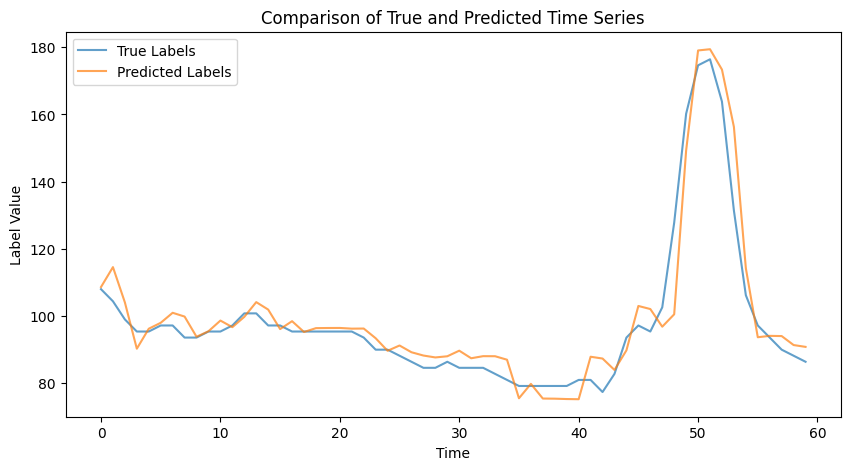

In [70]:
import matplotlib.pyplot as plt

# 画出比对图
plt.figure(figsize=(10, 5))
plt.plot(all_targets[-60:], label='True Labels', alpha=0.7)
plt.plot(all_predictions[-60:], label='Predicted Labels', alpha=0.7)
plt.legend()
plt.title('Comparison of True and Predicted Time Series')
plt.xlabel('Time')
plt.ylabel('Label Value')
plt.show()